## Train and Evaluate a PyTorch-Based Classifier

This notebook demonstrates the process of building, training, and evaluating a **PyTorch-based Convolutional Neural Network (CNN)** for image classification. 

#### Step 1: Configuration and library imports

In [18]:
import warnings 
warnings.filterwarnings("ignore")
import os
import sys
import time
import shutil
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


CPU times: total: 0 ns
Wall time: 23.6 μs


In [20]:
extract_dir = "."

#### Step 2: Ensuring repetability in PyTorch

To achieve reproducible results when we train a CNN in PyTorch, we must follow these three steps:
1. Define a helper called `set_seed` that seeds every random-number generator and configures cuDNN for deterministic kernels.
2. Call `set_seed()` once at the top of our script to lock in the seed for the main process.
3. Provide a `worker_init_fn` so each `DataLoader` worker starts from a reproducible seed as well.

Define the `set_seed` function 

What `set_seed` function does
- **Python & NumPy** - Many data-pipeline utilities (shuffling lists, image augmentations) rely on these random-number generators. Seeding them first removes one entire layer of randomness.
- **PyTorch CPU/GPU** - `torch.manual_seed` covers every op executed on the CPU, while `torch.cuda.manual_seed_all` applies the same seed to each GPU stream so that multi-GPU jobs stay in sync.
- **cuDNN flags** - By default cuDNN picks the fastest convolution algorithm, which can vay run-to-run. Setting `deterministic=True` forces repeatable kernels and turning `benchmark` *off* prevents the auto-tuner from replacing those kernels mid-training.

In [21]:
def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""

    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN: force repeatable convolutions
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Call `set_seed()`

Running the command before you build models, create datasets, or start data-loader workers gurantees that every downstream object inherits the same seed. If you call it later, some layers or tensors may already have been initialized with non-deterministic values, breaking repeatability.

In [22]:
SEED = 42
set_seed(SEED)
print(f"Global seed set to {SEED} -- main process is now detemrinistc.")

Global seed set to 42 -- main process is now detemrinistc.


*Why is random initialization useful for the model?*

→ Random initialization (starting your model's weights with random values instead of zeros or some fixed value), each neuron starts differently, enabling effective learning and convergence.

Define `worker_init_fn` function

PyTorch offsets each worker's seed by default, injecting new randomness. For reproducible results, we want workers to start from **fixed** seeds to every data-augmentation decision (flip, crop, colour-jitter) is repeatbale across runs. The `worker_init_fn` function re-seeds Python, NumPy, and PyTorch CPU random-number generators inside **each** worker using a simple deterministic formula (`SEED + worker_id`). The result will be identical batches, identical gradients, and identical model checkpoints, run after run.

In [23]:
def worker_init_fn(worker_id: int) -> None:
    # Re-seed each DataLoader worker so their RNGs do not collide.
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

Define `dataset_path` 

In [24]:
dataset_path = os.path.join(extract_dir, "images_dataSAT")
print(dataset_path)

.\images_dataSAT


#### Step 3: Defining hyperparameters and device

We have to define the key **hyperarameters** that control the model's training process. Hyperparameters are set by the user to configure the learning algorithm.
- `img_size`: The spatial resolution (height and width) to which all images will be resized. This ensures that the input to the neural network is of a consistent size.
- `batch_size`: The number of training examples utilized in one iteration (one forward and backward pass). A larger batch size can lead to faster training but requires more memory.
- `lr` (learning rate): A crucial hyperparameter that determines the step size at each iteration while moving towarf a minimum of the loss function.
- `epochs`: The number of times the learning algorithm will work through the entire training dataset.
- `model_name`: The name of the model file that will be created  after training. This is useful for saving the checkpoint while training.
- `device`: This line programmatically checks if a CUDA-enabled GPU is available using `torch.cuda.is_available()`. If a GPU is found, the device is set to `"cuda"` to leverage hardware acceleration. Otherwise, it defaults to the `"cpu"`. This makes the code portable and efficient.

In [25]:
img_size = 64
batch_size = 128
lr = 0.001
epochs = 9
model_name = "0_ibm_ai_capstone_project.pth"
num_classes = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used is {device}")

Device used is cuda


#### Step 4: The data pipeline

We have downloaded the dataset and fixed the initial random seed for reproducibility. Now, we can start to build the data pipeline to feed data for training the model. To create the data pipeline for PyTorch, we will:
1. Define transformations.
2. Split the dataset for training and validation.
3. Create the dataloader to feed the data into the training model.

Define transformation

Augmentation artificially expands the training dataset by creating modified versions of images, which helps the model generalize better and reduces overfitting. The pipeline also resizes the iamge, converts it to a PyTorch tensor, and normalizes its pixel values. This cell constructs the entire pipeline for loading and preparing the image data for the model. It involves defining transformations, splitting the data, and creating data loaders.

In [26]:
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # It normalizes the image so each RGB channel matches the mean and standard deviation of ImageNet images, making pixel values roughly centered around 0 with unit variance.
])

In [27]:
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # It normalizes the image so each RGB channel matches the mean and standard deviation of ImageNet images, making pixel values roughly centered around 0 with unit variance.
])

For normalization, if we don't want/need to match the ImageNet images, we could just go with [0.5, 0.5, 0.5]. Here is how we could draw the line: 

✅ Use **ImageNet normalization** if you’re using a pretrained model (e.g., ResNet, VGG, EfficientNet, etc.) — it ensures your inputs match what the model expects.

✅ Use your **own normalization** (e.g., [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) if you’re training a model from scratch or working with non-natural images (like microscopy or satellite data), so the normalization reflects your dataset’s actual pixel distribution.

Loading dataset

We have defined the transformation pipelines for the training and validation datasets.

Next, we will use the `datasets.ImageFolder` utility to load an image dataset from the root directory `dataset_path`.

This root directory contains the subdirectories where each subdirectory corresponds to a class (e.g, `data/agri`, `data/non_agri`)

In [28]:
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

Dataset split: Train and validation

We can use `random_split` and `torch.utils.data` class.

This method will allow use to randomly split the input data based on a pre-defined split ratio for the training and validation datasets.

In this case, we will use 80% for training and 20% for validaiton.

In [29]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

Create training dataloader

Now, we will use the `DataLoader` from `torch.utils.data` class to create a dataset generator for lazy loading of the training dataset. In the input we will define:
- `train_dataset`
- `batch_size`
- `shuffle`: Set to True to load images from the dataset in random order
- `num_workers`: Numer of parallel processes used to load the images. This is for optimum utilization of our CPU cored to reduce the image I/O bottleneck
- `worker_init_fn`: For function to decide on data augmentation. The default is with random seed for better generalization or fixed seed for reproducible results. 

In [30]:
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0,
    worker_init_fn = worker_init_fn
)

In [31]:
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0,
    worker_init_fn = worker_init_fn
)

- `train_transform` defines a sequence of operations to be applied to the training imageds. It includes **data augmentaiton** techniques like `RandomRotation`, `RandomHorizontalFlip`, and `RandomAffine`. The pipeline also resizes the image, converts it to a PyTorch tensor, and normalizes its pixel values.
- `val_transform` is for the validation set. It omits the random augmentaion steps because we want to evaluate the model's performance on the original, unaltered data.
- `datasets.ImageFolder`, this PyTorch utility automatically loads an image dataset from a directory where subdirectories are named after their corresponsing classes (e.g, `data/agri`, `data/non_agri`).
- `random_split`: The full datset is partioned into training and validation sets. This seperation is crucial for assessing how well the model generalizes to unseen data.
- `DataLoader`: These objects wrap the datasets and provide an efficient, iterable way to feed data to the model in batches. `shuffle=True` for the `train_loader` ensures that the model sees the data in a different order each epoch, which helps prevent it from learning the order of the training examples. `worker_init_fn` ensures that **fixed seed** is passed to the `dataloader` for reproducibility. 

#### Step 5: Define the model

We will define the Convolutional Neural Network (CNN) architecture and configure the components needed for training.

- `model = nn.Sequential(...)`: A sequetial container is used to build the model as a linear stack of layers. This is a convenient way to define a straightforward CNN.
    - Convolutional Blocks: The model consists of several blocks, each containing
        - a `Conv2d` layer for feature extraction,
        - a `ReLU` activation function,
        - a `MaxPool2d` layer to downsample and reduce dimensionality,
        - a `BatchNorm2d` to stabalize and accelrate training. 
    
    - Classifier: After the convolutional blocks,
        - `AdaptiveAvgPool2d` reduces each feature map to a single value, making the model more robust to input size variations.
        - `Flatten` converts the 2D feature maps into a 1D vector. 
        - `Linear` (fully connected) layers then perform the final classification.
        - `Dropout` is used as a regularization technique to prevent overfitting.
    
    - `.to(device)`: This moves the model's parameters and buffers to the selcted device (GPU, if available other CPU).


In [32]:
model = nn.Sequential(
    # Conv Block 1
    nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),

    # Conv Block 2-6
    nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
    nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),

    # Classifier
    nn.AdaptiveAvgPool2d(1), nn.Flatten(),
    nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
    nn.Linear(2048, num_classes)
).to(device)

#### Step 6: Define the training setup

After defining the model, we declare the loss function and the optimizer for backpropagation and learning. We also sat up the tracking of the history of the model training for loss and accuracy for every step of the model training.

- The loss function is defined using `criterion = nn.CrossEntropyLoss()` 
    - `CrossEntropyLoss` is specifically designed for multi class classification problems.

- The optimizer is defined using `optimizer = optim.Adam()`
    - The  `Adam` optimizer is chosen to update the model's weights. It is an adaptive learning rate method that is computationally efficient and works well in practice.

- We can track the hisotry using `best_loss`, `loss_history` and `acc_history` dictionaries
    - `best_loss`: stores the best validation achieved so far.
    - `loss_history` and `acc_history` dictionaries to log the loss and accuracy history for plotting later.


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_loss = float('inf')
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

#### Step 7: Training and validation

Our neural network is now ready for training. 

Here, we will set up the main logic for how the model learns from the data. The model iterated through the dataset for the specified number of epochs, with each epoch consisting of a training phase and a validaiton phase.

- Our Loop (`for epoch in range (epochs)`): Controls the number of full passes over the dataset.

- Training Phase:
    - `model.train()`: Sets the model to training mode. This activates layers like Dropout and ensures BatchNorm layers learn from the current batch statistics. 
    - `optimizer.zero_grad()`: Clears the gradients from the previous iteration before computing new ones.
    - `outputs = model(images)`: **Forward Pass**. The input data is passed through the network to get predictions (logits).
    - `loss.backward()`: **Backward Pass**. Gradients of the loss with respect to the model's parameters are calculated.
    - `optimizer.step()`: The optimizer updates the model's parameters using the computed gradients.

- Validation Phase:
    - `model.eval()`: Sets the model to evaluation mode. This deactivates Dropout and makes BatchNorm layers use their learned runing statistics.
    - `with torch.no_grad()`: Disables gradients calculation, which speeds up computation and reduces memory usage since we are only evaluating, and not training.

- **Model Checkpointing**: After each epoch, the current validaiton loss is compared to the `best_loss` seen so far. If the current loss is lower, the model's state (`model.state_dict()`) isa saved to a file. This ensures that we keep the model version that performed best on validation set. 

In [34]:
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

for epoch in range(epochs):
    # Training Phase
    start_time = time.time()
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0 # for the training metrics
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        images, labels = images.to(device), labels.to(device) # labels as integer class indices
        optimizer.zero_grad()
        outputs = model(images) # outputs are raw logits
        loss = criterion(outputs, labels) # criterion is nn.CrossEntropyLoss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    # Synchronize CUDA before stopping timer (if using GPU)
    if device == 'cuda':
        torch.cuda.synchronize()

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0 # for the validation metrics
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim = 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Save the best model
    avg_val_loss = val_loss/len(val_loader)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model, model_name)

    # Store metrics
    loss_history['train'].append(train_loss/len(train_loader))
    loss_history['val'].append(val_loss/len(val_loader))
    acc_history["train"].append(train_correct/train_total)
    acc_history["val"].append(val_correct/val_total)

    print(f"Train Loss: {loss_history['train'][-1]:.4f} | Val Loss: {loss_history['val'][-1]:.4f}")
    print(f"Train Acc: {acc_history['train'][-1]:.4f} | Val Acc: {acc_history['val'][-1]:.4f}")
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} training completed in {epoch_time:.2f} seconds \n")

print("Trained Model. Now evaluating the model...")





Training on : ===cuda=== with batch size: 128 & lr: 0.001


Epoch 1/9: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Train Loss: 0.2044 | Val Loss: 0.0190
Train Acc: 0.9433 | Val Acc: 0.9933
Epoch 1 training completed in 39.34 seconds 



Epoch 2/9: 100%|██████████| 38/38 [00:04<00:00,  9.42it/s]


Train Loss: 0.0214 | Val Loss: 0.0132
Train Acc: 0.9912 | Val Acc: 0.9933
Epoch 2 training completed in 4.82 seconds 



Epoch 3/9: 100%|██████████| 38/38 [00:03<00:00,  9.83it/s]


Train Loss: 0.0118 | Val Loss: 0.0111
Train Acc: 0.9958 | Val Acc: 0.9958
Epoch 3 training completed in 4.65 seconds 



Epoch 4/9: 100%|██████████| 38/38 [00:03<00:00,  9.74it/s]


Train Loss: 0.0144 | Val Loss: 0.0078
Train Acc: 0.9950 | Val Acc: 0.9975
Epoch 4 training completed in 4.69 seconds 



Epoch 5/9: 100%|██████████| 38/38 [00:03<00:00, 10.08it/s]


Train Loss: 0.0118 | Val Loss: 0.0086
Train Acc: 0.9944 | Val Acc: 0.9967
Epoch 5 training completed in 4.44 seconds 



Epoch 6/9: 100%|██████████| 38/38 [00:03<00:00, 10.17it/s]


Train Loss: 0.0094 | Val Loss: 0.0232
Train Acc: 0.9969 | Val Acc: 0.9900
Epoch 6 training completed in 4.41 seconds 



Epoch 7/9: 100%|██████████| 38/38 [00:03<00:00, 10.21it/s]


Train Loss: 0.0285 | Val Loss: 0.0052
Train Acc: 0.9908 | Val Acc: 0.9983
Epoch 7 training completed in 4.48 seconds 



Epoch 8/9: 100%|██████████| 38/38 [00:03<00:00, 10.25it/s]


Train Loss: 0.0143 | Val Loss: 0.0048
Train Acc: 0.9948 | Val Acc: 0.9983
Epoch 8 training completed in 4.47 seconds 



Epoch 9/9: 100%|██████████| 38/38 [00:03<00:00, 10.25it/s]


Train Loss: 0.0301 | Val Loss: 0.0546
Train Acc: 0.9940 | Val Acc: 0.9800
Epoch 9 training completed in 4.37 seconds 

Trained Model. Now evaluating the model...


Great results, let us evaluate the model.

#### Step 8: Visualizing training history

Here we will use `matplotlib` to create plots of the model's acccuract and loss over each epoch. Visualizing these metrics is useful for understanding the training dynamics.

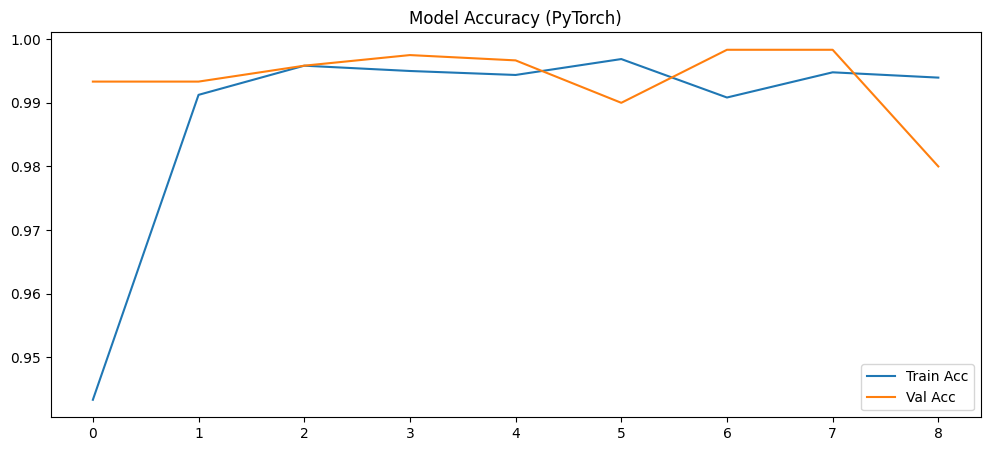

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(acc_history['train'], label='Train Acc')
plt.plot(acc_history['val'], label='Val Acc')
plt.title("Model Accuracy (PyTorch)")
plt.legend()
plt.show()

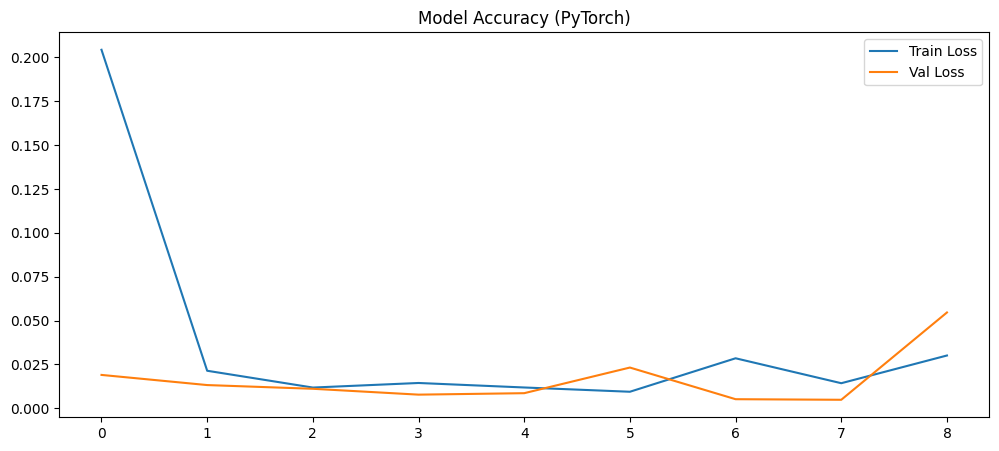

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['val'], label='Val Loss')
plt.title("Model Accuracy (PyTorch)")
plt.legend()
plt.show()

Final Model Evaluation.

This cell comprehensively evaluates the best-performing model saved during the training loop. While accuracy provides a high-level view, these metrics provide a deeper insight into the model's behaviour.

- `model.eval()`: Switches the model to evaluatoin model.
- `with torch.no_grad()`: Disabled gradient computation for efficiency. 
- **Collecting Predictions**: The code iterated through the entire validation set to gather all predictions and their corresponsing truel labels.
- `accuracy`: The proportion of correct predictions out of the total predictions.

In [37]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"The accuracy of the model is: {accuracy: .4f}")

NameError: name 'all_labels' is not defined

In [ ]:
all_preds = []
all_labels = []

model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.numpy())

print(all_preds)
print(all_labels)

[np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)